# Source

#### https://github.com/karpathy/nn-zero-to-hero/blob/master/lectures/makemore/makemore_part4_backprop.ipynb
#### https://www.youtube.com/watch?v=q8SA3rM6ckI&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=5

In [112]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [113]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [114]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [115]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [116]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
def cmp(s, dt, t):
  torch.set_printoptions(precision=8)
  ex = torch.all(dt == t.grad).item()
  app = torch.allclose(dt, t.grad)
  maxdiff = (dt - t.grad).abs().max().item()
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [117]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 64 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1 # using b1 just for fun, it's useless because of BN
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

# Note: I am initializating many of these parameters in non-standard ways
# because sometimes initializating with e.g. all zeros could mask an incorrect
# implementation of the backward pass.

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

4137


In [118]:
batch_size = 32
n = batch_size # a shorter variable also, for convenience
# construct a minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

In [119]:
# forward pass, "chunkated" into smaller steps that are possible to backward one at a time

emb = C[Xb] # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
# Linear layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre-activation
# BatchNorm layer
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
# Non-linearity
h = torch.tanh(hpreact) # hidden layer
# Linear layer 2
logits = h @ W2 + b2 # output layer
# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# PyTorch backward pass
for p in parameters:
  p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik there is no cleaner way
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
  t.retain_grad()
loss.backward()
loss


tensor(3.32059336, grad_fn=<NegBackward0>)

# Excercise 1
### Find Derivatives through the whole process

In [120]:
W2.shape

torch.Size([64, 27])

In [143]:
# Manually (own solution)

# dy/dx 
# dloss/dlogprobs
# loss = -1 * (a + b + c + ... + k) / n
# loss = -1/n*a + -1/n*b + -1/n*c ... + -1/n*k
# dloss/da = -1/n
# dloss/db = -1/n
# ...
# 
dlogprobs =  torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1/n
cmp('logprobs', dlogprobs, logprobs)

# dloss/dprobs
# Local derivative:
# dL/dprobs: log(probs)  |  log(x): 1/x
# 1/probs
# Chainrule:
# 1/probs*dlogprobs

dprobs = 1/probs * dlogprobs
cmp('probs', dprobs, probs)


# dloss/dcounts_sum_inv
# counts_sum_inv = counts_sum**-1
# -1 * counts_sum**-2 * dprobs

dcounts_sum_inv = torch.zeros_like(counts_sum_inv)
dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)

#Can't check here since counce sum inv depends on counts which I'll do later
dcounts = counts_sum_inv * dprobs
cmp('counts', dcounts, counts)

dcounts_sum = -1 *counts_sum**-2 * dcounts_sum_inv
cmp('counts_sum', dcounts_sum, counts_sum)

dcounts += torch.ones_like(counts) * dcounts_sum
cmp('counts', dcounts, counts)

dnorm_logits= norm_logits.exp() * dcounts
cmp('norm_logits', dnorm_logits, norm_logits)


dlogits = dnorm_logits.clone()
cmp('logits', dlogits, logits)


dlogit_maxes = (-dnorm_logits).sum(1, keepdim=True)
cmp('logit_maxes', dlogit_maxes, logit_maxes)

dlogits += F.one_hot(logits.max(1).indices, num_classes= logits.shape[1]) * dlogit_maxes
cmp('logits', dlogits, logits)

#logits = h @ W2 + b2 # output layer
dh = dlogits @ W2.T
dW2 = h.T @ dlogits
db2 = dlogits.sum(0)

cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)

dhpreact = (1-torch.tanh(hpreact)**2) * dh
#dhpreact = (1.0-h**2) * dh   # equivalent

cmp('hpreact', dhpreact, hpreact)



#hpreact = bngain * bnraw + bnbias
dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
cmp('bngain', dbngain, bngain)

dbnraw = bngain * dhpreact
cmp('bnraw', dbnraw, bnraw)
#hpreact = bngain * bnraw + bnbias

dbnbias = dhpreact.sum(0, keepdim=True)
cmp('bnbias', dbnbias, bnbias)


#bndiff2 = bndiff**2
#bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)

dbndiff = bnvar_inv * dbnraw # noch nicht korrekt: bndiff geht noch in bndiff2 rein
cmp('bndiff', dbndiff, bndiff)

dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)

dbnvar = (-0.5 * (bnvar + 1e-5)**-1.5) * dbnvar_inv
cmp('bnvar', dbnvar, bnvar)

#dbndiff2 = 1/(n-1) * torch.ones_like(bndiff2) * dbnvar
dbndiff2 = 1/(n-1)  * dbnvar
cmp('bndiff2', dbndiff2, bndiff2)

dbndiff += 2*bndiff * dbndiff2
cmp('bndiff', dbndiff, bndiff)


#emb = C[Xb] # embed the characters into vectors
#embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
# Linear layer 1
#hprebn = embcat @ W1 + b1 # hidden layer pre-activation

dhprebn = dbndiff.clone() # something is still missing
cmp('hprebn', dhprebn, hprebn)

dbnmeani = -dbndiff.sum(0, keepdim=True)
cmp('bnmeani', dbnmeani, bnmeani)

dhprebn += torch.ones_like(hprebn) * 1/n * dbnmeani
cmp('hprebn', dhprebn, hprebn)


dembcat = dhprebn @ W1.T
cmp('embcat', dembcat, embcat)

dW1 = embcat.T @ dhprebn
cmp('W1', dW1, W1)

db1 = dhprebn.sum(0)
cmp('b1', db1, b1)


#emb = C[Xb] # embed the characters into vectors
#embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
demb = dembcat.view(emb.shape) # put back in old shape
cmp('emb', demb, emb)

dC = torch.zeros_like(C)
for i in range(Xb.shape[0]): # iterate over rows: 32
    for j in range(Xb.shape[1]): # iterate over columns: 3
        ix = Xb[i,j] 
        dC[ix] += demb[i, j]
        #print(i, j)

cmp('C', dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: False | approximate: False | maxdiff: 0.005610490683466196
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: False | approximate: True  | maxdiff: 5.122274160385132e-09
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10
bngain   

In [136]:
Xb.shape[0]

32

In [123]:
print()

# Excercise 2

In [144]:
# Exercise 2: backprop through cross_entropy but all in one go
# to complete this challenge look at the mathematical expression of the loss,
# take the derivative, simplify the expression, and just write it out

# forward pass

# before:
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

# now:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

3.3205933570861816 diff: 0.0


In [231]:
import math 
dlogits = F.softmax(logits, 1)

# equivalent
dlogits_ = torch.zeros(32,27)
for i in range(len(dlogits_)):
    for j in range(len(dlogits_[0])):
        dlogits_ = logits.exp() / logits.exp().sum(1, keepdims=True)

dlogits_[range(n), Yb] -= 1
dlogits_ /= n
len(dlogits_)

#dlogits

32

In [232]:
cmp('logits', dlogits_, logits) # I can only get approximate to be true, my maxdiff is 6e-9


logits          | exact: False | approximate: True  | maxdiff: 4.6566128730773926e-09


#### Comparison: We push the probility of the correct value to one and pull down the probablities of the incorrect values to be zero
#### The gradient is the effect on the loss. Intuitively, the correct value should have a negative effect on the loss (loss is minimized), while the other character should not have any effect at all.

In [237]:
dlogits_.sum(1) # row sums are zero

tensor([-2.32830644e-10, -3.25962901e-09, -3.72529030e-09, -2.79396772e-09,
         1.39698386e-09, -1.86264515e-09, -1.39698386e-09,  3.25962901e-09,
        -2.79396772e-09, -1.16415322e-09, -9.31322575e-10,  3.72529030e-09,
         9.31322575e-10, -3.25962901e-09, -1.16415322e-09, -3.49245965e-09,
         9.31322575e-10,  2.79396772e-09, -9.31322575e-10, -2.32830644e-09,
        -4.65661287e-10, -1.62981451e-09, -9.31322575e-10, -1.62981451e-09,
        -1.86264515e-09,  0.00000000e+00,  2.32830644e-10,  1.16415322e-09,
        -2.79396772e-09,  1.39698386e-09, -1.86264515e-09,  1.62981451e-09],
       grad_fn=<SumBackward1>)

In [239]:
dlogits_[0] * n

tensor([ 0.07736547,  0.08558806,  0.01605983,  0.04424230,  0.01830548,
         0.08165498,  0.02398051,  0.03947157, -0.98193550,  0.03381820,
         0.03634686,  0.04121972,  0.03327779,  0.02725406,  0.03191340,
         0.01387656,  0.00887026,  0.02066619,  0.01623388,  0.05009785,
         0.05933364,  0.02194253,  0.02402211,  0.06971362,  0.05699923,
         0.02569012,  0.02399129], grad_fn=<MulBackward0>)

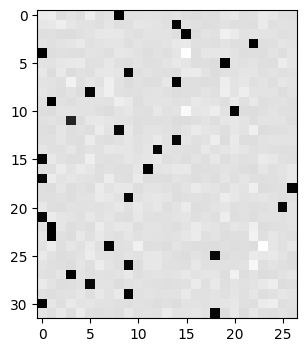

In [235]:
plt.figure(figsize=(4, 4))
plt.imshow(dlogits_.detach(), cmap='gray')